# Import files

In [1]:
from Strats.PairTradingStrat import *
from Strats.PortfolioMetrics import *

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Get all available tickers
response = requests.get(f"{BASE_URL}/ticker/price")
data = response.json()
tickers = [i["symbol"] for i in data]

In [ ]:
coint_pairs = get_coint_pairs(tickers, max_pairs=300, interval = '1d', start_date="2023-01-01", end_date="2023-12-31")

  0%|          | 19/4900015 [00:09<764:28:41,  1.78it/s]

In [3]:
with open('Strats/pairs/saved_pairs.pkl', 'rb') as f:
    coint_pairs = pickle.load(f)


In [4]:
test_pair = coint_pairs[0]
print(test_pair)

symbol_manager = BinanceSymbolManager()
# Add symbols
print(symbol_manager.add_symbol(test_pair[0]))  # Success
print(symbol_manager.add_symbol(test_pair[1]))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
pair_portfolio = price_fetcher.get_grp_historical_ohlcv(
        interval="1d",
        start_date="2023-01-01",
        end_date="2023-12-31"
    )

pair_portfolio

('ETHBTC', 'ASTBTC')
'ETHBTC' added successfully.
'ASTBTC' added successfully.


,timestamp,ASTBTC,ETHBTC
0,2023-01-01,0.000005,0.072238
1,2023-01-02,0.000005,0.072814
2,2023-01-03,0.000005,0.072840
3,2023-01-04,0.000005,0.074581
4,2023-01-05,0.000005,0.074336
...,...,...,...
575,2024-07-29,0.000001,0.049680
576,2024-07-30,0.000001,0.049540
577,2024-07-31,0.000001,0.050010
578,2024-08-01,0.000001,0.049010


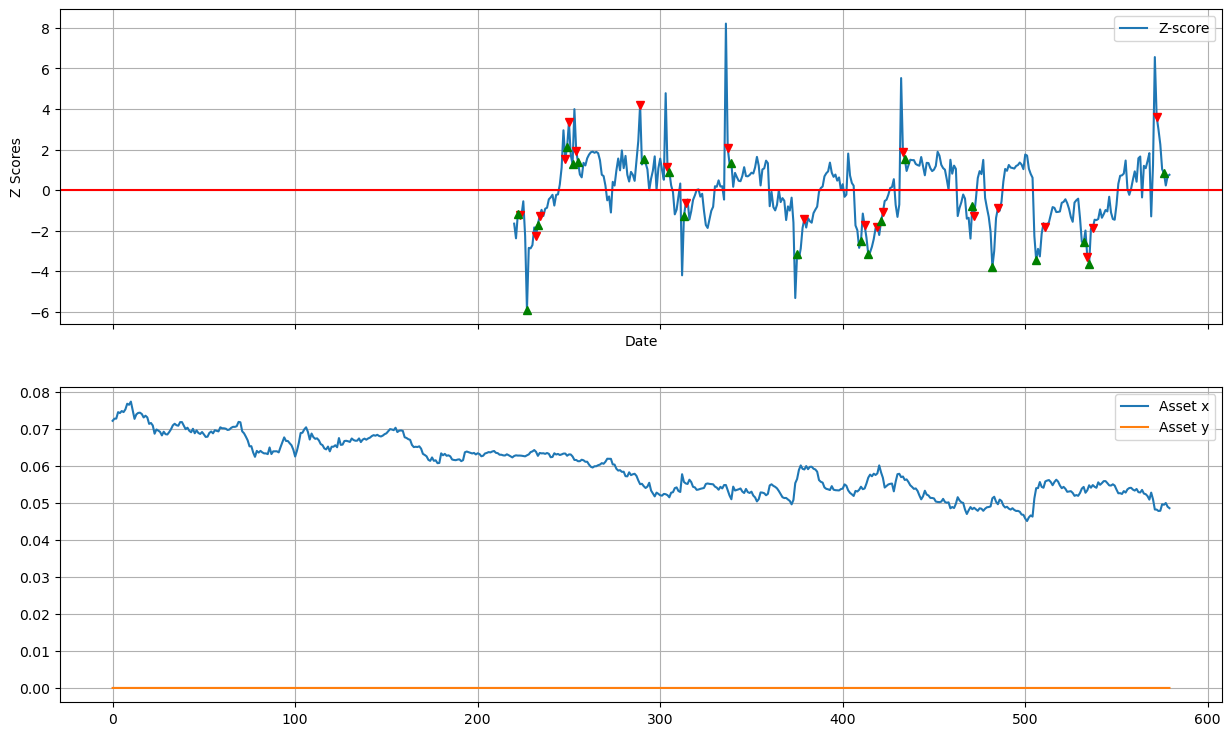

In [5]:
model = pair_trading(pair_portfolio[test_pair[0]], pair_portfolio[test_pair[1]], lookback=200, ZSCORE_ENTRY=2)
spread = model.compute_spread()
z_scores = model.compute_z_score(20)
df = model.generate_signals()
model.plot_signals(df)

In [6]:
model.computePnL(df)

,z_scores,beta,z_signal,positions,BUY_or_SELL,x_pnl,y_pnl,daily_pnl,cumulative_pnl,daily_return
0,NaN,0.000124,0,0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
1,NaN,0.000124,0,0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2,NaN,0.000124,0,0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
3,NaN,0.000124,0,0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
4,NaN,0.000124,0,0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
575,1.026699,0.000124,-1,-1,0,0.000000,0.000000,0.000000,-4.422832e-06,0.000000e+00
576,0.829532,0.000124,0,0,1,0.000006,-0.000001,0.000005,3.726465e-07,4.795479e-11
577,0.225994,0.000124,0,0,0,0.000000,0.000000,0.000000,3.726465e-07,0.000000e+00
578,0.684634,0.000124,0,0,0,0.000000,0.000000,0.000000,3.726465e-07,0.000000e+00


In [7]:
returns = model.computePnL(df)[("daily_return")]

port_metrics = PortfolioMetrics(returns.dropna())
summary = port_metrics.summary(risk_free_rate=0.02)  # 2% risk-free rate
print(summary)

         Annualized Return  Annualized Volatility  Sharpe Ratio  \
Returns       1.618483e-12           1.897954e-10 -1.053767e+08   

         Max Drawdown Duration  Max Drawdown  Calmar Ratio  Skewness  \
Returns                    143 -9.756795e-11      0.016588  0.012858   

          Kurtosis  VaR (5%)     CVaR (5%)  Tail Ratio  Omega Ratio  
Returns  11.348542       0.0 -1.656079e-12         NaN     1.004025  
